In [128]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like','dislike','stop','rock','peace']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = "../gesture_dataset_sample"

## helper function to load and parse annotations

In [129]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [130]:
annot_test = dict()
with open(f'annot-johannes.json') as f:
    annot_test = json.load(f)

In [131]:
# pretty-print first element
print(json.dumps(annotations['like']['0a245bef-2894-4b80-93bb-15fc26dc5ffb'], indent=2))

{
  "bboxes": [
    [
      0.36014919,
      0.77555186,
      0.03375774,
      0.06189803
    ],
    [
      0.46752245,
      0.47008987,
      0.0433003,
      0.07942283
    ]
  ],
  "labels": [
    "no_gesture",
    "like"
  ],
  "landmarks": [
    [],
    [
      [
        0.501357363816233,
        0.5250908121638677
      ],
      [
        0.4977713122223854,
        0.5111957865046843
      ],
      [
        0.49124377771947325,
        0.4984946239624881
      ],
      [
        0.487178186823625,
        0.4886811121991978
      ],
      [
        0.48552113062771846,
        0.4804272631972185
      ],
      [
        0.4807027409559707,
        0.5040614544395914
      ],
      [
        0.47330661017413767,
        0.5115544465603905
      ],
      [
        0.47689492969143144,
        0.5140015344255021
      ],
      [
        0.4810105759118617,
        0.5129608964487755
      ],
      [
        0.47995315315484915,
        0.5134275581164951
      ],
      [
   

## helper function to pre-process images (color channel conversion and resizing)

In [132]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [133]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [134]:
my_images = [] # stores actual image data
my_labels = [] # stores labels (as integer - because this is what our network needs)
#label_names = [] # maps label ints to their actual categories so we can understand predictions later
path = "photos"
# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for filename in tqdm(os.listdir(path)):
    # extract unique ID from file name
    UID = filename.split('.')[0]
    img = cv2.imread(f'{path}/{filename}')

    # get annotation from the dict we loaded earlier
    try:
        annotation = annot_test[UID]
    except Exception as e:
        print(e)
        continue

    # iterate over all hands annotated in the image
    for i, bbox in enumerate(annotation['bboxes']):
        # annotated bounding boxes are in the range from 0 to 1
        # therefore we have to scale them to the image size
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h

        # crop image to the bounding box and apply pre-processing
        crop = img[y1:y2, x1:x2]
        preprocessed = preprocess_image(crop)

        # get the annotated hand's label
        # if we have not seen this label yet, add it to the list of labels
        label = annotation['labels'][i]
        if label not in label_names:
            label_names.append(label)
        print(label)
        label_index = label_names.index(label)

        my_images.append(preprocessed)
        my_labels.append(label_index)

  0%|          | 0/15 [00:00<?, ?it/s]

dislike
dislike
dislike
like
like
like
peace
peace
peace
rock
rock
rock
stop
stop
stop


## let's have a look at one of the images

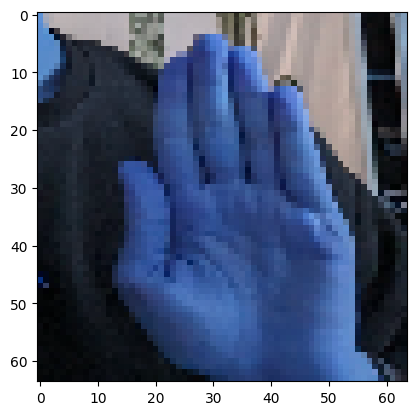

In [136]:
plt.imshow(random.sample(my_images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1301
326
1301
326


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [124]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1301, 64, 64, 3) (326, 64, 64, 3) (1301, 6) (326, 6)


In [137]:
#like above but with my data
my_x_test = np.array(my_images).astype('float32')
my_x_test = my_x_test / 255.

my_test_label = to_categorical(my_labels)

my_y_test = my_labels #bei emma gesehen

my_x_test = my_x_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)


print(my_x_test.shape, my_test_label.shape)

(15, 64, 64, 3) (15, 6)


In [138]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [139]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1826 - loss: 1.8023 - val_accuracy: 0.2362 - val_loss: 1.7729 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2287 - loss: 1.7714 - val_accuracy: 0.4356 - val_loss: 1.3983 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3770 - loss: 1.5670 - val_accuracy: 0.5000 - val_loss: 1.3299 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5198 - loss: 1.1946 - val_accuracy: 0.4969 - val_loss: 1.1334 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6484 - loss: 0.9280 - val_accuracy: 0.8190 - val_loss: 0.6066 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7537 - loss: 0.6262 - val_accuracy: 0.8037 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7870 - loss: 0.

In [140]:
# let's have a look at our model
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_7               │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,428 (1.13 MB)

 Trainable params: 99,142 (387.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 198,286 (774.56 KB)

## Plot accuracy and loss of the training process

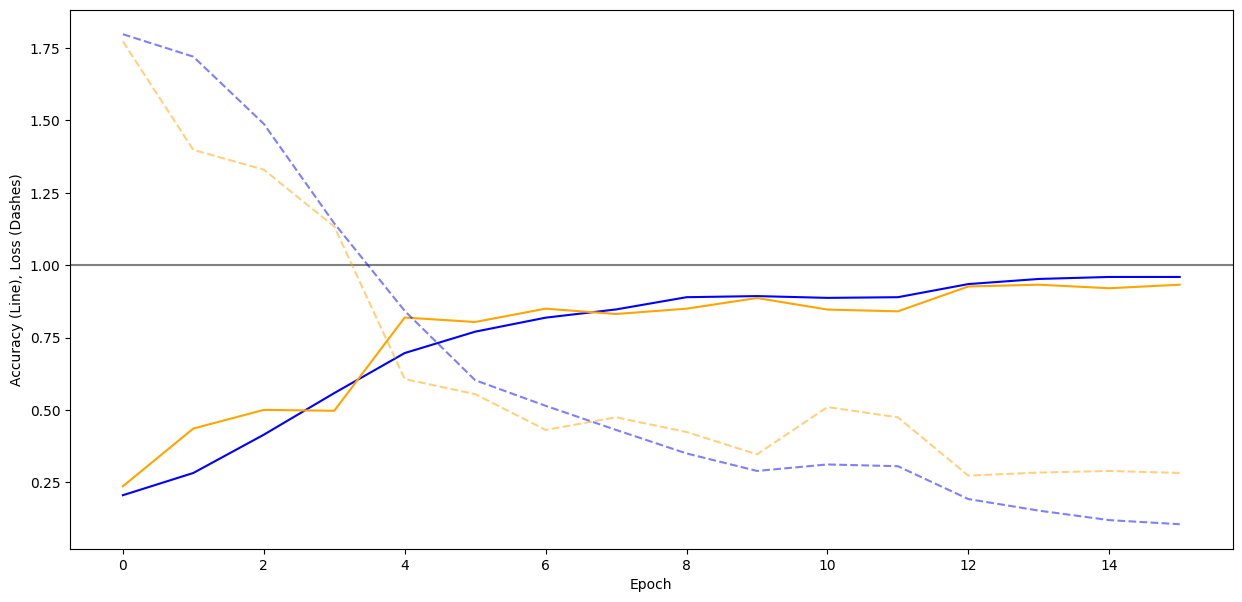

In [141]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [142]:
model.save('gesture_recognition.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
before [[1.8190354e-07 1.2694163e-06 2.6443092e-09 9.9999845e-01 2.1280859e-11
  4.8319576e-10]
 [2.6663853e-08 2.1943172e-06 5.0424235e-12 1.5369127e-10 9.9920648e-01
  7.9134462e-04]
 [4.4120065e-05 9.6972311e-01 2.8263206e-02 2.5058018e-05 1.8098144e-03
  1.3465337e-04]
 ...
 [6.1887037e-03 5.0443789e-04 1.8943429e-04 9.9310875e-01 9.5178439e-07
  7.7200375e-06]
 [3.3575597e-01 1.1013493e-02 2.3205073e-03 6.4576119e-01 7.6312240e-04
  4.3857656e-03]
 [3.3009002e-07 3.1731904e-02 3.2512672e-04 6.1009402e-08 9.6677411e-01
  1.1685160e-03]]
probabilities [3 4 1 4 1 4 3 3 1 1 1 2 2 1 5 2 2 2 0 2 0 1 4 3 4 0 0 1 5 0 3 1 5 1 0 4 0
 5 0 1 2 1 4 0 3 2 4 5 4 5 1 3 1 3 5 1 1 4 0 0 0 5 4 4 4 1 5 2 1 2 2 3 1 1
 1 1 1 5 5 2 5 3 0 5 2 2 3 0 4 0 1 2 2 2 5 2 1 3 1 4 5 2 0 4 1 0 4 4 1 5 1
 2 1 1 1 4 2 2 1 2 4 1 4 2 0 1 2 2 3 1 5 5 3 0 0 3 2 0 1 2 3 0 0 0 2 4 4 3
 5 2 0 2 3 3 1 3 2 4 4 5 4 1 3 2 1 0 1 1 3 1 4 4 2 0 4 2 1 1 2 4 1 2 4 1 4
 1 4 5 4 1 3 1 5 4 2 2 3

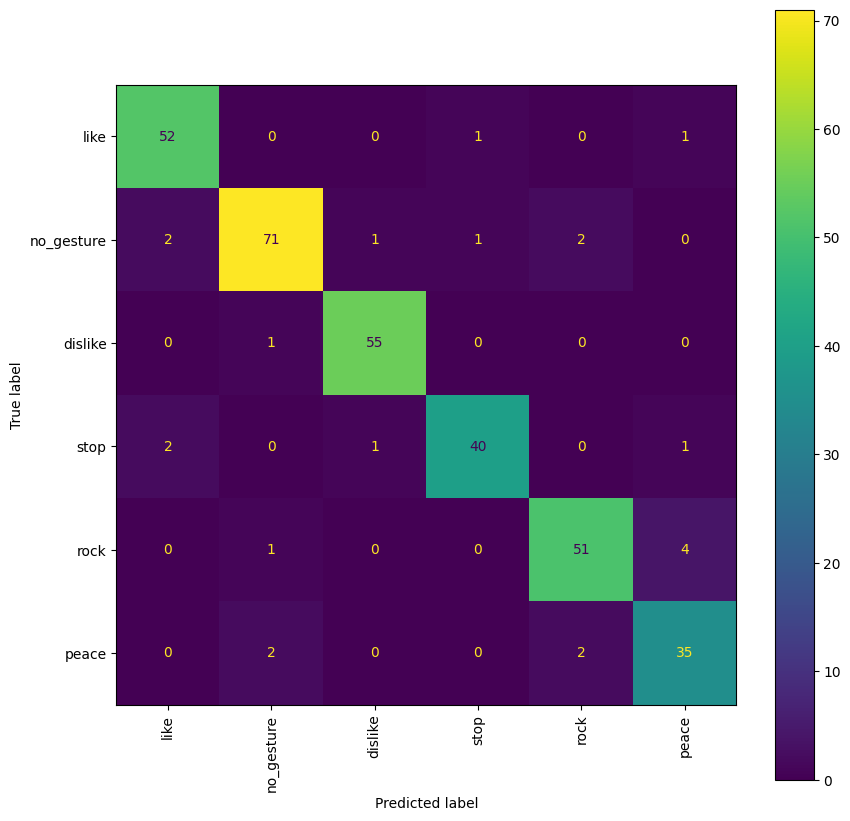

In [143]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
probabilities [2 2 2 0 0 0 5 5 5 5 4 5 3 3 1]
reality [2, 2, 2, 0, 0, 0, 5, 5, 5, 4, 4, 4, 3, 3, 3]


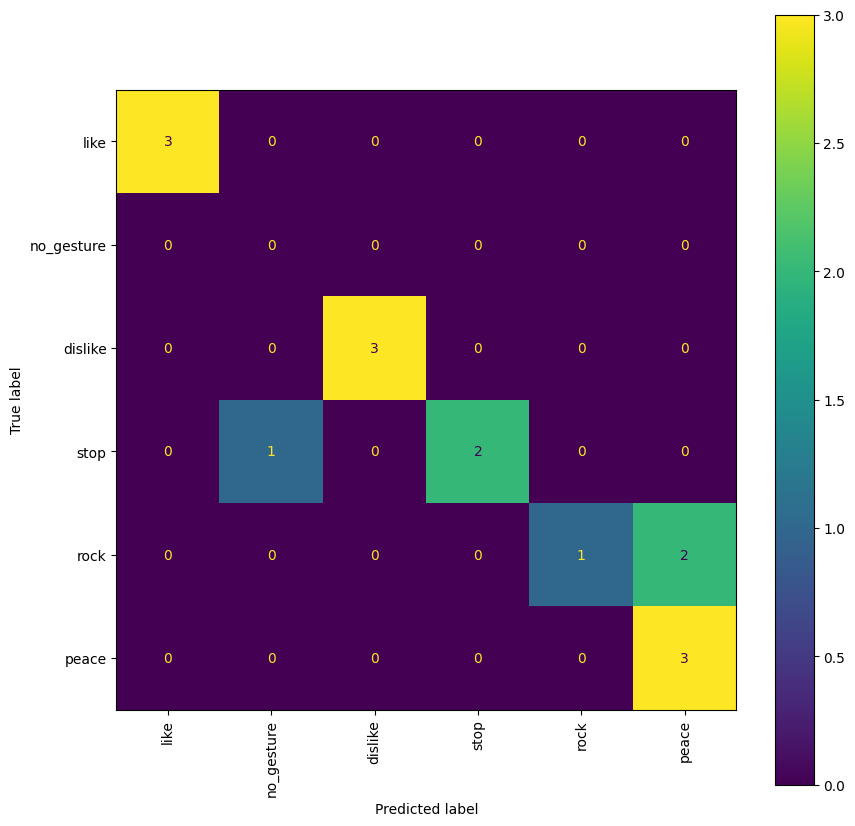

In [144]:
#test my data
my_y_predictions = model.predict(my_x_test)

my_y_predictions = np.argmax(my_y_predictions, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(my_y_test, my_y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
plt.savefig('conf_matrix.png',format='png')
pass
